# OS11 - Exercise 13

Solve the TSP with an original implementation of the genetic algorithm.

I have tested this algorithm with up to 100 cities and takes ~ half an hour to stop without problems.

In [1]:
from sympy import *

In [2]:
import random

In [3]:
import numpy as np

In [4]:
import scipy.linalg as linalg

In [5]:
from scipy.optimize import linprog

In [6]:
import matplotlib.pyplot as plt

In [7]:
from matplotlib import collections  as mc

In [8]:
import pylab as pl

In [9]:
import math

In [10]:
np.set_printoptions(threshold=1000)

### Problem Data

Size of area where random data point will be created:

In [11]:
L = 100

Number of random data points:

In [12]:
N = 20

Random seed:

In [13]:
seed = '100'

Population size:

In [14]:
Z = 100

Population random seed:

In [15]:
pop_seed = '200'

### New generation parameters

In [16]:
elite_size = int(0.1*Z) 

In [17]:
mutation_thereshold = 0.5

In [18]:
ramdon_selection_threshold = int(0.6*Z)   #new population members from elite_size up to random_selection_thereshold get selected by fitness random selection

In [19]:
#rest of the members are created by crossover

In [20]:
max_iterations_without_change = 1000

### Data points creation

In [21]:
random.seed(seed)

points = [(random.randrange(L), random.randrange(L)) for i in range(N)]

#points

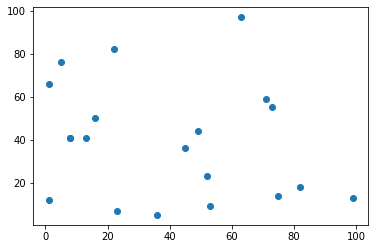

In [22]:
x, y = zip(*points)
plt.scatter(x, y)
plt.show()

### Distances array precomputation

At this stago I will not caveat with redundancy in distances matrix and so on.

In [23]:
def dist(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

In [24]:
DD = np.zeros((N, N))

In [25]:
for i in range(N):
    for j in range(N):
        DD[i, j] = dist(points[i], points[j])

#DD

### Initial population

In [26]:
random.seed(pop_seed)

In [27]:
def new_member(N):
    member = np.array(random.sample(range(N), N)).astype(int)
    return member

In [28]:
new_member(N)

array([12,  9,  8, 19, 18,  2, 17,  0,  6,  4, 13, 11, 10, 16,  7,  1,  3,
        5, 14, 15])

In [29]:
population = [new_member(N) for i in range(Z)]

#population

### Mutation function

In [30]:
#thereshold is probability of member od being mutated, spread is the mean distante between shifts
#where I want more shifts around consecutive nodes and less, but not 0, between separated nodes

def mutate_member(m, thereshold = 0.05, spread = 2):
    if random.random() > thereshold:
        return m
    o = random.randrange(N)
    s = floor(random.gauss(0, spread))
    d = (o + s)%N
    m1 = m[o]
    m[o] = m[d]
    m[d] = m1
    return m

### Crossover Function

In [31]:
def crossover_members(m1, m2):
    m2p = [m2[i] for i in range(N)]    
    s = random.randrange(N)
    q = random.randrange(2, N-1)
    m = np.roll(m1, s)
    for i in range(q):
        m2p.remove(m[i])
    
    for i in range(q, N):
        m[i] = m2p[i-q]

    return m

In [32]:
population[1]

array([12, 13,  4,  7, 11,  3, 16,  8, 15, 18,  0, 19,  2,  6,  9, 10,  1,
       14,  5, 17])

In [33]:
population[4]

array([ 7, 10, 15,  9, 19,  4, 13,  8,  0, 14, 11,  1,  6,  2,  3, 17, 16,
       18,  5, 12])

In [34]:
crossover_members(population[1], population[4])

array([19,  2,  6,  9, 10,  1, 14,  7, 15,  4, 13,  8,  0, 11,  3, 17, 16,
       18,  5, 12])

### Normalizing function

In order to facilitate crossovers and comparaison between members, I will apply a normalizing function. Only function is shift array so
each member starts with node 0.

In [35]:
def normalize_member(m):
    zero_pos = 0
    for i in range(N):
        if m[i] == 0:
            zero_pos = i
            break
    m = np.roll(m, -zero_pos)
    return m

In [36]:
population[5]

array([ 1, 14, 18,  9,  8,  4,  5,  0, 16, 11, 13,  3, 15,  7, 10,  6, 17,
       19, 12,  2])

In [37]:
normalize_member(population[5])

array([ 0, 16, 11, 13,  3, 15,  7, 10,  6, 17, 19, 12,  2,  1, 14, 18,  9,
        8,  4,  5])

### Member total distance function

In [38]:
def member_total_distance(m):
    dist = 0.0
    for i in range(N-1):
        dist += DD[m[i], m[i+1]]
    dist += DD[m[N-1], m[0]]
    return dist

In [39]:
member_total_distance(population[5])

1101.4773009869562

### Ordering

In [40]:
population.sort(key=member_total_distance)

In [41]:
#population

In [42]:
distances = [member_total_distance(m) for m in population]
#distances

### Printing

In [43]:
def print_results(p, d, n = 10):
    for i in range(n):
        print("# {0:3}: d:{1:.2f}  path: {2}".format(i, d[i], p[i]))

## Algorithm implementation

In [44]:
def ga_iteration(population, sorted = True):
    new_population = [None for i in range(Z)]
    random.seed()
    #sorting
    if sorted == False:
        population.sort(key=member_total_distance)
    
    for i in range(0, elite_size):
        new_population[i] = np.copy(population[i])
    
    for j in range(elite_size, ramdon_selection_threshold):
        p = None
        while not p:
            p = elite_size + random.weibullvariate(1, 1)*0.5*(Z-elite_size)
            p = p if p < Z else None
        new_population[j] = mutate_member(np.copy(population[int(p)]), mutation_thereshold)
    
    for i in range(ramdon_selection_threshold, Z):
        a = random.randrange(Z)
        b = random.randrange(Z)
        new_population[i] = crossover_members(population[a], population[b])
    
    #mutating
    #for i in range(Z):
    #    new_population[i] = mutate_member(new_population[i], mutation_thereshold)

    #normalizing
    for i in range(Z):
        new_population[i] = normalize_member(new_population[i])
    
    #sorting
    new_population.sort(key=member_total_distance)
    
    #distances:
    distances = [member_total_distance(m) for m in new_population]
    
    return new_population, distances

### Initial data

In [45]:
random.seed(pop_seed)
population = [normalize_member(new_member(N)) for i in range(Z)]

In [46]:
population.sort(key=member_total_distance)
distances  = [member_total_distance(m) for m in population]

In [47]:
print_results(population, distances)

#   0: d:835.44  path: [ 0 18  5 10 11 15  1 12  3  4  7 13  8 16 17  9  6  2 14 19]
#   1: d:861.74  path: [ 0 14 11  1  6  2  3 17 16 18  5 12  7 10 15  9 19  4 13  8]
#   2: d:894.31  path: [ 0  7 15 12 17 18  5 10  8 14  4 19  1  2 11  6  9  3 16 13]
#   3: d:902.62  path: [ 0  9  4 12 18 10  5  3 19 14  8  2  6 13 17  7 16 11 15  1]
#   4: d:909.25  path: [ 0  9 16 12  3  4 14 19  1 13 15  8  7 10  6 11  2  5 17 18]
#   5: d:914.91  path: [ 0 17  9 12 13 19  8  7 18  3  1 11  4 15  6 14  2 10  5 16]
#   6: d:927.75  path: [ 0  9 14 19  5 16  2 18  8  6 13 12 17 11  3 15 10  1  4  7]
#   7: d:934.21  path: [ 0 19 16  7  1  6  9 15  2 18 10  5 11  8 14 12 17 13  4  3]
#   8: d:950.63  path: [ 0 17 14 16  2  8  6  5 13  9  3 10 11 18  1  4 19 15  7 12]
#   9: d:953.40  path: [ 0  7 17 13 14  4 11 10  5 15 19 16  9 12  3  6  2 18  8  1]


### Iteration

In [48]:
iterations = 0
iterations_update = 100

finish = False

best = distances[0]
iterations_without_update = 0

while not finish:
    population, distances = ga_iteration(population, True)
    
    if distances[0] < best:
        best = distances[0]
        iterations_without_update = 0
    else:
        iterations_without_update +=1
    
    if iterations_without_update > max_iterations_without_change:
        finish = True
    
    if iterations % iterations_update == 0:
        print("Iterando... {0:6} iteraciones Mejor: {1:.2f}  {2}".format(iterations, best, population[0]))

    iterations+=1
    
print("Finalizado")

Iterando...      0 iteraciones Mejor: 804.92  [ 0 18  5 10 11  1 12  3  4  7 13  8 16  6  2 14 19  9 17 15]
Iterando...    100 iteraciones Mejor: 475.78  [ 0 16  2  5 18 17  3 14  4  9 19 12 13  7 15  1 11 10  8  6]
Iterando...    200 iteraciones Mejor: 380.02  [ 0 16  2  5 18  3 17 14 12  4  9 19 13  7  6 15  1 10 11  8]
Iterando...    300 iteraciones Mejor: 380.02  [ 0 16  2  5 18  3 17 14 12  4  9 19 13  7  6 15  1 10 11  8]
Iterando...    400 iteraciones Mejor: 380.02  [ 0 16  2  5 18  3 17 14 12  4  9 19 13  7  6 15  1 10 11  8]
Iterando...    500 iteraciones Mejor: 380.02  [ 0 16  2  5 18  3 17 14 12  4  9 19 13  7  6 15  1 10 11  8]
Iterando...    600 iteraciones Mejor: 380.02  [ 0 16  2  5 18  3 17 14 12  4  9 19 13  7  6 15  1 10 11  8]
Iterando...    700 iteraciones Mejor: 380.02  [ 0 16  2  5 18  3 17 14 12  4  9 19 13  7  6 15  1 10 11  8]
Iterando...    800 iteraciones Mejor: 380.02  [ 0 16  2  5 18  3 17 14 12  4  9 19 13  7  6 15  1 10 11  8]
Iterando...    900 iteracion

In [49]:
print_results(population, distances)

#   0: d:380.02  path: [ 0 16  2  5 18  3 17 14 12  4  9 19 13  7  6 15  1 10 11  8]
#   1: d:380.02  path: [ 0 16  2  5 18  3 17 14 12  4 19  9 13  7  6 15  1 10 11  8]
#   2: d:380.02  path: [ 0 16  2  5 18  3 17 14 12  4  9 19 13  7  6 15  1 10 11  8]
#   3: d:380.02  path: [ 0 16  2  5 18  3 17 14 12  4 19  9 13  7  6 15  1 10 11  8]
#   4: d:380.02  path: [ 0 16  2  5 18  3 17 14 12  4 19  9 13  7  6 15  1 10 11  8]
#   5: d:380.02  path: [ 0 16  2  5 18  3 17 14 12  4  9 19 13  7  6 15  1 10 11  8]
#   6: d:380.02  path: [ 0 16  2  5 18  3 17 14 12  4  9 19 13  7  6 15  1 10 11  8]
#   7: d:380.02  path: [ 0 16  2  5 18  3 17 14 12  4  9 19 13  7  6 15  1 10 11  8]
#   8: d:380.02  path: [ 0 16  2  5 18  3 17 14 12  4  9 19 13  7  6 15  1 10 11  8]
#   9: d:380.02  path: [ 0 16  2  5 18  3 17 14 12  4 19  9 13  7  6 15  1 10 11  8]


In [50]:
#print_results(population, distances, Z)

### Results

In [51]:
res = population[0]
lines = []
idxs = []

for i in range(N-1):
    lines.append([points[res[i]], points[res[i+1]]])
lines.append([points[res[N-1]], points[res[0]]])
lines

[[(45, 36), (49, 44)],
 [(49, 44), (73, 55)],
 [(73, 55), (71, 59)],
 [(71, 59), (63, 97)],
 [(63, 97), (22, 82)],
 [(22, 82), (5, 76)],
 [(5, 76), (1, 66)],
 [(1, 66), (16, 50)],
 [(16, 50), (13, 41)],
 [(13, 41), (8, 41)],
 [(8, 41), (8, 41)],
 [(8, 41), (1, 12)],
 [(1, 12), (23, 7)],
 [(23, 7), (36, 5)],
 [(36, 5), (53, 9)],
 [(53, 9), (75, 14)],
 [(75, 14), (99, 13)],
 [(99, 13), (82, 18)],
 [(82, 18), (52, 23)],
 [(52, 23), (45, 36)]]

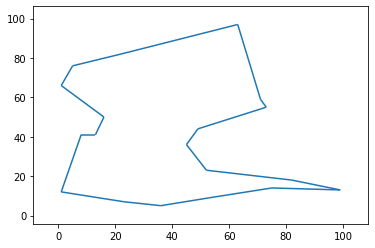

In [52]:
#lc = mc.LineCollection(lines, colors=c, linewidths=2)
lc = mc.LineCollection(lines)
fig, ax = pl.subplots()
ax.add_collection(lc)

ax.autoscale()
ax.margins(0.1)


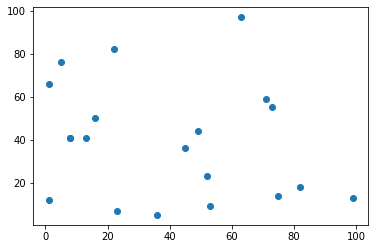

In [53]:
x, y = zip(*points)
plt.scatter(x, y)
plt.show()